In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import MinMaxScaler

# nice print of 1D list in 3 columns
def print3(oneDlist):
    temp = list(oneDlist)
    temp.extend([" "," "])
    for a,b,c in zip(temp[::3],temp[1::3],temp[2::3]):
        print('{:<30}{:<30}{:<}'.format(a,b,c))

In [2]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
train.shape , test.shape

((1460, 81), (1459, 80))

Drop and impute numerical columns

In [3]:
#drop cols with less than 70% info
drop_cols = [col for col in train.columns if train[col].isnull().sum(axis=0)/len(train) >=0.3]

train.drop(drop_cols, axis=1, inplace=True)

#impute missing numerical data
missing_num_cols = [col for col in train.select_dtypes(include=[np.number]).columns if train[col].isnull().any()]

train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")

for col in missing_num_cols:
    train_knn[col] = knn_imputer.fit_transform(train_knn[[col]])

In [4]:
num_feats = train_knn.select_dtypes(include=np.number)


x = pd.DataFrame(num_feats.drop(labels=['SalePrice'], axis=1))
y= np.log(pd.DataFrame(num_feats['SalePrice']))

Min_Max = MinMaxScaler()
X_train = Min_Max.fit_transform(x)
Y_train = Min_Max.fit_transform(y)

In [5]:
X_train

array([[0.00000000e+00, 2.35294118e-01, 1.50684932e-01, ...,
        0.00000000e+00, 9.09090909e-02, 5.00000000e-01],
       [6.85400960e-04, 0.00000000e+00, 2.02054795e-01, ...,
        0.00000000e+00, 3.63636364e-01, 2.50000000e-01],
       [1.37080192e-03, 2.35294118e-01, 1.60958904e-01, ...,
        0.00000000e+00, 7.27272727e-01, 5.00000000e-01],
       ...,
       [9.98629198e-01, 2.94117647e-01, 1.54109589e-01, ...,
        1.61290323e-01, 3.63636364e-01, 1.00000000e+00],
       [9.99314599e-01, 0.00000000e+00, 1.60958904e-01, ...,
        0.00000000e+00, 2.72727273e-01, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 1.84931507e-01, ...,
        0.00000000e+00, 4.54545455e-01, 5.00000000e-01]])

In [6]:
# Lasso Logistic
sel_ = SelectFromModel(LinearRegression())
sel_.fit(X_train, np.ravel(Y_train,order='C'))
sel_.get_support()
X_train = pd.DataFrame(X_train)

In [7]:
Lasso_feats = X_train.columns[(sel_.get_support())]
Lasso_feats2 = list(x.columns[Lasso_feats])
print('Lasso selected features: {} out of {}'.format(len(Lasso_feats),X_train.shape[1]))
print('Lasso selected features:')
print3(Lasso_feats2)

Lasso selected features: 14 out of 37
Lasso selected features:
LotArea                       OverallQual                   OverallCond
YearBuilt                     BsmtFinSF1                    TotalBsmtSF
1stFlrSF                      2ndFlrSF                      GrLivArea
BsmtFullBath                  TotRmsAbvGrd                  GarageCars
ScreenPorch                   PoolArea                       


In [31]:
# instantiate the model
reg = LinearRegression()

# fit the model
reg.fit(X_train, Y_train.ravel())

LinearRegression()

In [81]:
# # from scipy import stats
# X_train2 = x[Lasso_feats2].copy()

# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(method='yeo-johnson')

# X_train3 = pt.fit_transform(X_train2)

# for i in X_train3.columns:
#     fig, ax =plt.subplots(1,2)
#     sns.histplot(X_train3[i], ax=ax[0])
#     sns.histplot(X_train2[i], ax=ax[1])

# X_train3 = X_train2.apply(lambda x: stats.yeojohnson(x)[0])
    
# import statsmodels.api as sm
# X_train3 = sm.add_constant(X_train3)

# results = sm.OLS(y,X_train3).fit()
# results.summary()  

In [9]:
import statsmodels.api as sm

X_train3 = x[Lasso_feats2].copy()
X_train3 = sm.add_constant(X_train3)

results = sm.OLS(y,X_train3).fit()
results.summary()  

/home/lucas/Software/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                     602.5
Date:                Tue, 08 Mar 2022   Prob (F-statistic):               0.00
Time:                        15:54:53   Log-Likelihood:                 671.98
No. Observations:                1460   AIC:                            -1314.
Df Residuals:                    1445   BIC:                            -1235.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.5174      0.387      9.081      0.000       2.758       4.277
LotArea        2.68e-06   4.33e-07      6.188      0.000    1.83e-06    3.53e-06
OverallQual      0.0942      0.005     19.487      0.000       0.085       0.104
OverallCond      0.0594      0.004     14.766      0.000       0.052       0.067
YearBuilt        0.0035      0.000     17.645      0.000       0.003       0.004
BsmtFinSF1    2.344e-05   1.32e-05      1.771      0.077   -2.52e-06    4.94e-05
TotalBsmtSF   6.047e-05    1.8e-05      3.360      0.001    2.52e-05    9.58e-05
1stFlrSF      8.616e-05   8.74e-05      0.986      0.324   -8.53e-05       0.000
2ndFlrSF      4.196e-05   8.62e-05      0.487      0.626      -0.000       0.000
GrLivArea        0.0002   8.59e-05      1.993      0.046    2.71e-06       0.000
BsmtFullBath     0.0578      0.010      5.594      0.000       0.038       0.078
TotRmsAbvGrd     0.0118      0.005      2.599      0.009       0.003       0.021
GarageCars       0.0796      0.007     10.744      0.000       0.065       0.094
ScreenPorch      0.0004   7.31e-05      5.076      0.000       0.000       0.001
PoolArea        -0.0004      0.000     -3.637      0.000      -0.001      -0.000
==============================================================================
Omnibus:                     1105.544   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            67916.707
Skew:                          -2.949   Prob(JB):                         0.00
Kurtosis:                      35.888   Cond. No.                     1.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

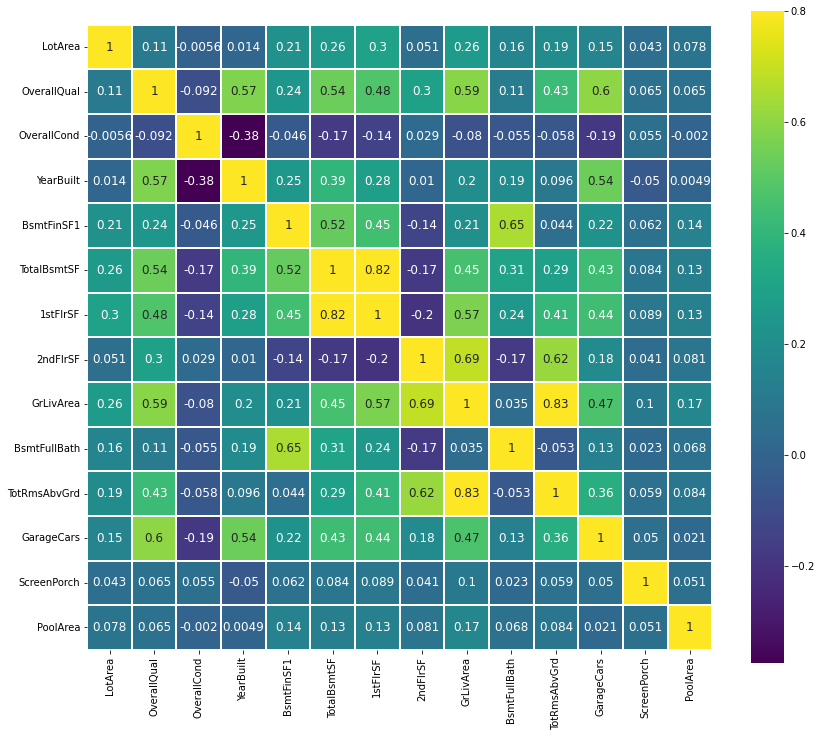

In [19]:
X_train3 = x[Lasso_feats2].copy()
cm = np.corrcoef(X_train3.values.T)
f , ax = plt.subplots(figsize = (14,12))
sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=True,cmap='viridis',
            linecolor="white",xticklabels = X_train3.columns.values ,annot_kws = {'size':12},yticklabels = X_train3.columns.values);

In [17]:
X_train3.columns.values

array(['const', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
       'BsmtFullBath', 'TotRmsAbvGrd', 'GarageCars', 'ScreenPorch',
       'PoolArea'], dtype=object)